# catboost

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import catboost as cb
from sklearn.model_selection import train_test_split

from collections import Counter

## 1. Data load

train data set 정리  
- train_origin : original train data set, f_score dataframe의 idx로 onehotencoding된 값까지 저장하기위해 사용
- train_set : features들 제거된 train data set
- train_t : validation과 나눠지기 전 train data set, 마지막 test set을 prediction 하기 전 전체 train set을 학습하기 위해 저장
- train : validation과 나눠진 후 train data set

In [25]:
train_origin = pd.read_csv('../../input/train.csv', na_values=['-1','-1.0'])
test_set = pd.read_csv('../../input/test.csv', na_values=['-1','-1.0'])

In [26]:
train_origin.shape

(595212, 59)

train_set의 origin columns를 저장하기 위해 copy

In [27]:
train_set = train_origin.copy()

## 2. Data cleaning

In [28]:
drop_feature = ['ps_ind_01', 'ps_car_11', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_03', 
               'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
               'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
               'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_13_bin', 'ps_calc_15_bin', 'ps_calc_16_bin',
               'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin',
               'ps_car_05_cat', 'ps_car_10_cat']
train_set = train_set.drop(drop_feature, axis=1)
test_set = test_set.drop(drop_feature, axis=1)

In [29]:
train_origin.shape

(595212, 59)

In [30]:
train_set.shape

(595212, 31)

## 3. Data split

train : validation = 7 : 3

In [69]:
x_data = train_set.drop(columns=['id','target'])
y_data = train_set['target']

test_idx = test_set['id']
test = test_set.drop(columns=['id'])

In [62]:
cat = [col for col in x_data.columns if 'cat' in col]
num = [col for col in x_data.columns if 'cat' not in col]

In [52]:
for cat_col in cat:
    x_data[cat_col] = x_data[cat_col].astype('category').cat.codes
    test[cat_col] = test[cat_col].astype('category').cat.codes

In [53]:
x_train, x_val, y_train, y_val = train_test_split(x_data,y_data,test_size=0.3,random_state=223)

In [36]:
cat_dims = [train_set.columns.get_loc(i) for i in cat]

[2, 4, 5, 19, 20, 21, 22, 23, 24, 25, 26, 27]

In [98]:
def catdata(df, num, cat, labels=None):
    if type(labels).__name__=='Series':
        cat_data = cb.Pool(
            data=cb.FeaturesData(
                num_feature_data=np.array(df[num], dtype=np.float32),
                cat_feature_data=np.array(df[cat], dtype=object),
                num_feature_names=num,
                cat_feature_names=cat
            )
        )
    else:
        cat_data = cb.Pool(
            data=cb.FeaturesData(
                num_feature_data=np.array(df[num], dtype=np.float32),
                cat_feature_data=np.array(df[cat], dtype=object),
                num_feature_names=num,
                cat_feature_names=cat
            ),
            label=np.array(labels)
        )
    return cat_data

In [99]:
train_t_cat = catdata(x_data, num, cat, labels=y_data)
train_cat = catdata(x_train, num, cat, labels=y_train)
val_cat = catdata(x_val, num, cat, labels=y_val)
test_cat = catdata(test, num, cat)

AttributeError: 'float' object has no attribute 'encode'

## 4. Catboosting

In [154]:
def gini(pred, actual, cmpcol=0, sortcol=1):
    if type(actual).__module__ == 'xgboost.core':
        actual = actual.get_label()
    if type(pred).__module__ == 'xgboost.core':
        pred = pred.get_label()
    
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(p, a):
    return 'gini_normal', gini(p, a) / gini(a, a)

In [ ]:
def model_tuning(params, gridsearch_params, dtrain_t, num_boost_round, nfold=5, seed=1223, es=20):
    max_gini = float("Inf")
    best_p = None

    for tune_p in gridsearch_params:
        # parameter setting
        print("CV with", end=" ")
        for i in range(len(tune_p)):
            print("{} : {} ".format(list(tune_p.keys())[i], list(tune_p.values())[i]), end=" ")

        # Update our parameters
        for i in range(len(tune_p)):
            params[list(tune_p.keys())[i]] = list(tune_p.values())[i]

        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=seed,
            nfold=nfold,
            feval=gini_normalized,
            maximize=True,
            early_stopping_rounds=es
        )
        # Update best MAE
        mean_gini = cv_results['test-gini_normal-mean'].max()
        boost_rounds = cv_results['test-gini_normal-mean'].idxmax()
        print("\n Gini normalized {} for {} rounds".format(mean_gini, boost_rounds))
        if mean_gini < max_gini:
            min_gini = mean_gini
            best_params = list(tune_p.values())[i]

    print("Best params: {}, Gini_normalized: {}".format(best_params, max_gini))

# 5. Parameter tuning

https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [211]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'ctr_border_count':[50,5,10,20,100,200],
          'thread_count':4}

### Step1, max_depth, min_child_weight tuning

In [212]:
gridsearch_params = [
    {'max_depth':max_depth, 'min_child_weight':min_child_weight}
    for max_depth in np.arange(3,10,2)
    for min_child_weight in np.arange(1,6,2)
]

In [ ]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

CV with max_depth : 3  min_child_weight : 1  \Gini normalized 0.2722356 for 192 rounds
CV with max_depth : 3  min_child_weight : 3  \Gini normalized 0.272033 for 199 rounds
CV with max_depth : 3  min_child_weight : 5  \Gini normalized 0.27218960000000003 for 173 rounds
CV with max_depth : 5  min_child_weight : 1  

In [195]:
params

{'learning_rate': 0.1,
 'n_estimators': 200,
 'max_depth': 3,
 'min_child_weight': 1,
 'gamma': 0,
 'subsample': 1,
 'colsample_bytree': 1,
 'objective': 'gpu:binary:logistic',
 'nthread': 4,
 'scale_pos_weight': 1,
 'tree_method': 'gpu_hist',
 'predictor': 'gpu_predictor'}

[0]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.166098	validation-gini_normal:0.164448
Multiple eval metrics have been passed: 'validation-gini_normal' will be used for early stopping.

Will train until validation-gini_normal hasn't improved in 20 rounds.
[5]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.218811	validation-gini_normal:0.215847
[10]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.219602	validation-gini_normal:0.217623
[15]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.224345	validation-gini_normal:0.221426
[20]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.230539	validation-gini_normal:0.228453
Stopping. Best iteration:
[0]	train-error:0.036352	validation-error:0.03667	train-gini_normal:0.166098	validation-gini_normal:0.164448



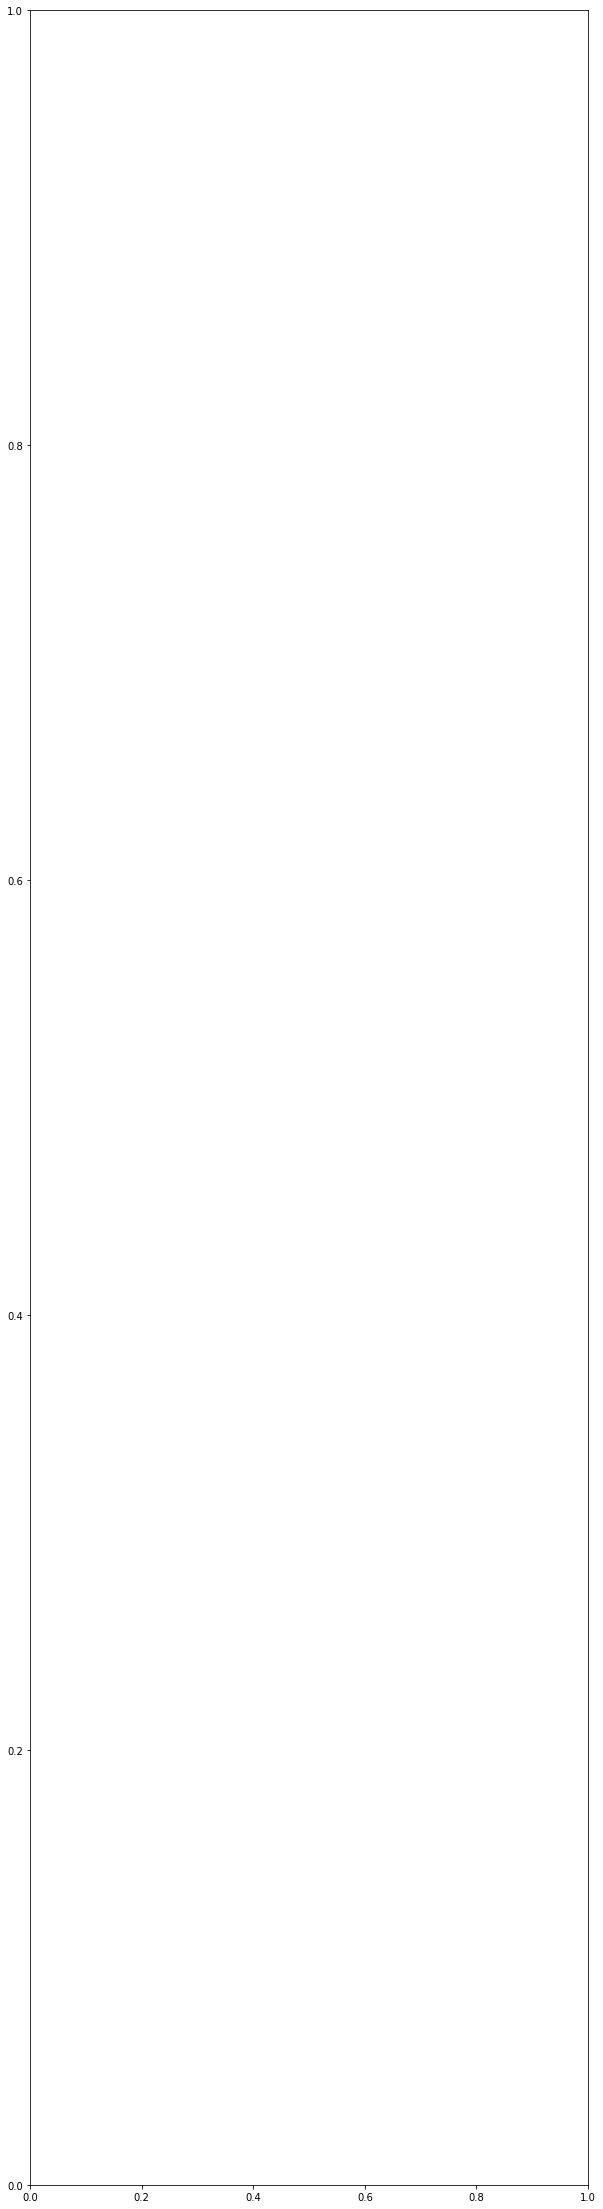

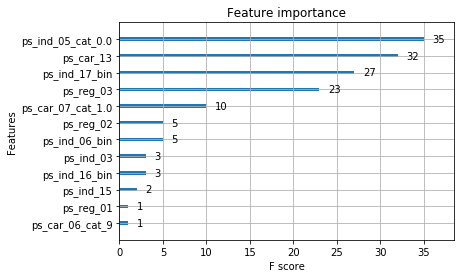

In [196]:
watchlist = [(dtrain,'train'), (dval,'validation')]
model = xgb.train(params, dtrain_t, num_boost_round=1000, evals=watchlist, 
                  feval=gini_normalized, verbose_eval=5, early_stopping_rounds=20)

In [ ]:
f, ax = plt.subplots(1,1, figsize=(10,40))
xgb.plot_importance(model)
plt.show()

### Step2, Gamma

In [ ]:
gridsearch_params = [
    {'gamma':i/10.0}
    for i in np.arange(0,5)
]

In [ ]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

### Step3, subsample, colsample_bytree

In [ ]:
gridsearch_params = [
    {'subsample':i/10.0, 'colsample_bytree':i/10.0}
    for i in np.arange(6,10)
]

In [ ]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

### Step4. reg_alpha

In [ ]:
alpha = [1e-5, 1e-2, 0.1, 1, 100]
gridsearch_params = [
    {'reg_alpha': i}
    for i in alpha
]

In [ ]:
%%time
model_tuning(params, gridsearch_params, dtrain_t, 200)

In [97]:
filename = 'f_score5.csv'

value = pd.Series(alg4.get_booster().get_fscore()).sort_values(ascending=False)
ranking = pd.DataFrame({'id':value.index, 'value':value, 'rank':list(range(1,len(value)+1))})
idx_df = pd.DataFrame({'id':train_origin.columns[2:], 'idx':list(range(1,len(train_origin.columns[2:])+1))})
f_score_df = pd.merge(ranking,idx_df, how='right')
f_score_df = f_score_df.sort_values(by='idx')
f_score_df.to_csv('../../input/' + filename)
f_score_df

,id,value,rank,idx
75,ps_ind_01,NaN,NaN,1
2,ps_ind_03,150.0,3.0,2
16,ps_ind_06_bin,24.0,17.0,3
20,ps_ind_07_bin,22.0,21.0,4
21,ps_ind_08_bin,21.0,22.0,5
19,ps_ind_09_bin,23.0,20.0,6
76,ps_ind_10_bin,NaN,NaN,7
77,ps_ind_11_bin,NaN,NaN,8
72,ps_ind_12_bin,2.0,73.0,9
78,ps_ind_13_bin,NaN,NaN,10


## 6. Submission

In [98]:
predictors = [x for x in train_t.columns if x not in ['id','target']]
alg4.fit(train_t[predictors], train_t['target'], eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=364,
       n_jobs=1, nthread=4, objective='gpu:binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=0.022634009295096912, seed=1223,
       silent=True, subsample=0.7, tree_method='gpu_hist')

In [99]:
test_pred = alg4.predict_proba(test)[:,1]

In [100]:
filename = 'submission10.csv'
pd.DataFrame({'id':test_idx, 'target':test_pred}).to_csv('../../input/' + filename,index=False)